# Forecasting using ARIMA type methods 
* Guides with codes on https://ranasinghiitkgp.medium.com/time-series-forecasting-using-lstm-arima-moving-average-use-case-single-multi-variate-with-code-5dd41e32d1fc
* Here we try out and compare different forecasting methods:
  * Linear regression
  * K-nearest neighbours
  * ARIMA
    * Vanilla
    * Models from Olga's codes:
        * ARIMA with exogenous vars 
        * Vanill recursive ARIMA 
        * Recursive ARIMA with exogenous vars 
  * LSTM (long short term memory)
* We use data from 2019-Q1 to 2021-Q3
    * Compute the RMSE for each model on 2021-Q4 data (leave-the-latest-out validationn)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# install and import necessary packages 

!pip install geopandas rtree &> /dev/null 

import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
import os
import pickle
import matplotlib.pyplot as plt

print(os.getcwd())

Mounted at /content/drive
/content


In [ ]:
## Load the source data
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')



with open('./cd-w-avg-with-dist.p', 'rb') as file:
  data = pickle.load(file)

data.head(5)

,PRUID,CDUID,avg_lat_ms,distance,SACTYPE,DA_POP,devices,tests,geometry,conn_type,time,avg_d_mbps,avg_u_mbps
0,61,6101.0,36.755102,6.425546,8.000000,448.265306,19.0,49.0,"MULTIPOLYGON (((4642490.038 4066985.206, 46426...",fixed,2019-Q1,14.574776,5.991551
1,61,6102.0,28.585366,444.526332,8.000000,747.073171,16.0,41.0,"MULTIPOLYGON (((4695765.369 3628102.680, 46958...",fixed,2019-Q1,26.693902,3.160341
2,61,6103.0,324.200000,104.673055,8.000000,330.000000,3.0,5.0,"MULTIPOLYGON (((5032382.179 3158440.088, 50322...",fixed,2019-Q1,11.964200,0.841000
3,61,6104.0,24.850000,306.145252,8.000000,739.250000,15.0,40.0,"MULTIPOLYGON (((4567677.409 3073390.226, 45678...",fixed,2019-Q1,9.468550,1.158050
4,61,6106.0,29.559838,9.110629,3.212982,630.091278,240.0,493.0,"MULTIPOLYGON (((5094536.880 3094447.671, 50944...",fixed,2019-Q1,52.260937,7.403355


In [ ]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6948 entries, 0 to 0
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PRUID       6948 non-null   object  
 1   CDUID       6948 non-null   float64 
 2   avg_lat_ms  6948 non-null   float64 
 3   distance    6948 non-null   float64 
 4   SACTYPE     6948 non-null   float64 
 5   DA_POP      6948 non-null   float64 
 6   devices     6948 non-null   float64 
 7   tests       6948 non-null   float64 
 8   geometry    6948 non-null   geometry
 9   conn_type   6948 non-null   object  
 10  time        6948 non-null   object  
 11  avg_d_mbps  6948 non-null   float64 
 12  avg_u_mbps  6948 non-null   float64 
dtypes: float64(9), geometry(1), object(3)
memory usage: 759.9+ KB


In [ ]:
# create a subset of data for avg_d_mbps
d_data = data[['CDUID', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices', 'tests', 'conn_type', 'time']]

## convert time (year-quarter) to datetime format (year-month)
from datetime import datetime 

years = list(range(2019, 2022))
months = ['03-31', '06-30', '09-30', '12-31']
year_months = []
for year in years:
    for month in months:
        year_months.append(str(year) + '-' + month)
year_quarters = sorted(d_data['time'].unique())

d_data['time'] = d_data['time'].replace(dict(zip(year_quarters, year_months)))
d_data['time'] = pd.to_datetime(d_data['time'])
d_data['time'] = pd.to_datetime(d_data['time'], format('%Y-%m'))

## convert CDUID to categorical variable
d_data['CDUID'] = d_data['CDUID'].astype('category')
d_data['conn_type'] = d_data['conn_type'].astype('category')
d_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6948 entries, 0 to 0
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CDUID       6948 non-null   category      
 1   avg_d_mbps  6948 non-null   float64       
 2   distance    6948 non-null   float64       
 3   DA_POP      6948 non-null   float64       
 4   SACTYPE     6948 non-null   float64       
 5   devices     6948 non-null   float64       
 6   tests       6948 non-null   float64       
 7   conn_type   6948 non-null   category      
 8   time        6948 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](1), float64(6)
memory usage: 465.1 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
## split training set and validation set
val_time = year_months[-1]
train_idx = d_data['time'] != val_time
val_idx = d_data['time'] == val_time
train_set = d_data.loc[train_idx, :]
val_set = d_data.loc[val_idx, :]

# create a subset to store true values and forecasts
f_set = val_set[['CDUID', 'conn_type', 'avg_d_mbps']]
# As we train & make forecasts, create a column for that model and store it.
# for example, 
# f_set['model1'] = preds
# f_set

# create a dataframe to store the errors
mse_df = pd.DataFrame(val_set.loc[:,['CDUID', 'conn_type']])
mse_df

# one-hot encode the categories
data_onehot = pd.get_dummies(data = d_data, columns = ['CDUID', 'conn_type'], drop_first=True) # drop_first gives k-1 dummy variables instead of k

train_x = data_onehot.loc[train_idx, :].drop(columns=['avg_d_mbps'])
train_y = data_onehot.loc[train_idx, 'avg_d_mbps']
val_x = data_onehot.loc[val_idx, :].drop(columns=['avg_d_mbps'])
val_y = data_onehot.loc[val_idx, 'avg_d_mbps']

In [ ]:
## Linear regression

### Prepare data
data_lin = data_onehot.copy()

### Make features? (like, make time a numerical variable?)
times = sorted(d_data.loc[:,'time'].unique())
time_ints = [*range(1,len(times)+1)]
data_lin.loc[:,'time_int'] = data_lin.loc[:,'time'].replace(to_replace=times, value = time_ints)

### Split train, val data
lin_train_set = data_onehot.loc[train_idx, :]
lin_x_train = lin_train_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_train = lin_train_set[['avg_d_mbps']]

lin_val_set = data_onehot.loc[val_idx, :]
lin_x_valid = lin_val_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_valid = lin_val_set.loc[:,'avg_d_mbps']

### Implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(lin_x_train, lin_y_train)

### make predictions
lr_preds = model.predict(lin_x_valid)

f_set.loc[:,'LR'] = lr_preds

## compute errors
mse_df.loc[:,'LR'] = np.concatenate(lr_preds) - f_set.loc[:, 'avg_d_mbps']
lr_rmse = np.sqrt(np.sum(np.square(mse_df.loc[:,'LR']))/len(lr_preds))
print(lr_rmse)

42.191847419703905


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
## k-Nearest Neighbours

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_tr_scaled_df = pd.DataFrame(scaler.fit_transform(lin_x_train))
x_val_scaled_df = pd.DataFrame(scaler.fit_transform(lin_x_valid))

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4]}
knn = neighbors.KNeighborsRegressor()
k_model = GridSearchCV(knn, params, cv=4)

#fit the model and make predictions
k_model.fit(x_tr_scaled_df, train_y)
k_preds = k_model.predict(x_val_scaled_df)

f_set['k-nearest'] = k_preds
mse_df['k-nearest'] = k_preds - f_set.loc[:, 'avg_d_mbps']
mse_df
k_rmse = np.sqrt(np.sum(np.square(mse_df.loc[:,'k-nearest']))/len(k_preds))
print(k_rmse)

40.5836747866392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
## Vanilla ARIMA
!pip install pmdarima &> /dev/null

from pmdarima.arima import auto_arima

## prepare data
ar_train = d_data.loc[train_idx, ['CDUID', 'conn_type', 'avg_d_mbps']]
ar_val = d_data.loc[val_idx, ['avg_d_mbps', 'conn_type']]
ar_val['ar_forecast'] = 0

## For auto_arima, we must fit and forecast for each CDUID

ar_preds = pd.DataFrame(data= ar_train[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
ar_models = {}

for id in ar_train['CDUID'].unique():
    
    print('processing: {pr}'.format(pr=id))
    # ar_subset = np.array(sorted(ar_train.loc[ar_train['CDUID']== id, 'avg_d_mbps']))
    ar_set = ar_train.loc[ar_train['CDUID']==id, :]
    
    for t in ar_set['conn_type'].unique():
        try:
            ar_subset = np.array(ar_set.loc[ar_set['conn_type']==t, 'avg_d_mbps'])
        except:
            break
        
        if len(ar_subset) > 3:
            ar_model = auto_arima(ar_subset, 
                            start_p=0, 
                            start_q=0,
                            max_p=3, 
                            max_q=3, 
                            start_P=0, 
                            seasonal=False,
                            d=1, 
                            information_criterion = 'bic',
                            D=0, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True
                            )
            ar_sub_dict = {t: ar_model} ## store best fit model for each conn_type
            temp_pred = ar_model.predict(n_periods = 1)[0]
        else:
            try:
                temp_pred = ar_subset[-1]
            except:
                print('problem at {pr}'.format(pr=id))
                temp_pred = ar_subset
        ar_models[id] = ar_sub_dict # store best fit models for each CDUID
        print('{pr} and {pred}'.format(pr=id, pred=temp_pred))
        ar_pred_idx = (ar_preds['CDUID']==id) & (ar_preds['conn_type'] == t)
        ar_preds.loc[ar_pred_idx, 'ar_forecast'] = temp_pred

print(len(ar_preds))

f_set2 = pd.merge(f_set, ar_preds, how='left', on = ['CDUID', 'conn_type'])

## RMSE of the ARIMA model
ar_rmse = np.sqrt(np.sum(np.square(f_set2.loc[:, 'ar_forecast'] - f_set2.loc[:, 'avg_d_mbps'])) / len(f_set2))
print(ar_rmse)

In [ ]:
## diagnostics
# model.plot_diagnostics(figsize=(7,5))
# plt.show()

In [ ]:
## ARIMA with exogenous variables

## exogenous variables: Here, we treat variables other than avg_d_mbps as exogenous variables
ar_exo_vars = ['distance', 'DA_POP', 'SACTYPE', 'devices']

## prepare data
ar_exo_data = d_data[['CDUID','conn_type', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices']]

## For auto_arima, we must fit and forecast for each CDUID

ar_exo_preds = pd.DataFrame(data= ar_exo_data[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
ar_exo_preds['ar_exo_forecast'] = 0
ar_exo_models = {}


ids = ar_exo_data['CDUID'].unique()
ids_new = ids
# ids_new = ids[145:]

for id in ids_new:
    
    print('processing: {pr}'.format(pr=id))
    
    ar_set = ar_exo_data.loc[ar_exo_data['CDUID']==id, ['conn_type', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices']]
    
    for t in ar_set['conn_type'].unique():
        try:
            ar_exo_subset = ar_set.loc[ar_set['conn_type']==t, :].reset_index()
            ar_exo_subset_train = ar_exo_subset.iloc[:-1]
            ar_exo_subset_val = ar_exo_subset.iloc[[-1]]
        except:
            print('error!, len={ln}'.format(ln = len(ar_exo_subset)))
            break
        
        if len(ar_exo_subset) > 3:
            ar_exo_model = auto_arima(ar_exo_subset_train.loc[:, 'avg_d_mbps'], 
                            start_p=0, 
                            start_q=0,
                            max_p=3, 
                            max_q=3, 
                            start_P=0, 
                            seasonal=False,
                            d=1, 
                            information_criterion = 'bic',
                            D=0, 
                            exogenous = ar_exo_subset_train.loc[:, ar_exo_vars],
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True
                            )
            ar_exo_sub_dict = {t: ar_exo_model} ## store best fit model for each conn_type
            # ar_exo_val_idx = (ar_exo_subset_val['CDUID'] == id) & (ar_exo_subset_val['conn_type']==t)
            print('{id}, {conn_type}'.format(id=id, conn_type=t))
            temp_pred = ar_exo_model.predict(n_periods = 1, exogenous= ar_exo_subset_val.loc[:, ar_exo_vars])[0]
        
        elif len(ar_exo_subset) == 1:
            temp_pred = ar_exo_subset['avg_d_mbps'][0]
            
        else:   
            try:
                temp_pred = ar_exo_subset_train.loc[:,'avg_d_mbps'].iloc[-1]
            except:
                print('problem at {pr}'.format(pr=id))
                
        ar_exo_models[id] = ar_exo_sub_dict # store best fit models for each CDUID
        print('{pr} and {pred}'.format(pr=id, pred=temp_pred))
        ar_exo_pred_idx = (ar_exo_preds['CDUID']==id) & (ar_exo_preds['conn_type'] == t)
        ar_exo_preds.loc[ar_exo_pred_idx, 'ar_exo_forecast'] = temp_pred

print(len(ar_exo_preds))

f_set4 = pd.merge(f_set3, ar_exo_preds, how='left', on = ['CDUID', 'conn_type'])

## RMSE of the ARIMA model
ar_exo_rmse = np.sqrt(np.sum(np.square(f_set2.loc[:, 'ar_exo_forecast'] - f_set2.loc[:, 'avg_d_mbps'])) / len(f_set2))
print(ar_exo_rmse)

In [ ]:
## check the models

# ar_models
# ar_exo_models

## save ar_models:

# ar_type_models = {'ar': ar_models, 'ar_exo': ar_exo_models}

# with open('../sonny_dir/arima_models_cd.p', 'wb') as file:
#     pickle.dump(ar_type_models, file)

## save results:
models = ['LR', 'k-nearest', 'ARIMA', 'ARIMA_exo']
rmse = []
for model in models:
    rmse.append(np.sqrt(np.sum(np.square(f_set4.loc[:, model] - f_set4.loc[:, 'avg_d_mbps'])) / len(f_set4)))
rmse_table = pd.DataFrame(np.array([models, rmse]))
rmse_table

E11_results = {'f_set': f_set4, 'rmse':rmse_table, 'ar': ar_models, 'ar_exo': ar_exo_models}
with open('./output-data/E11-results.p', 'wb') as file:
    pickle.dump(E11_results, file)

FileNotFoundError: ignored

In [ ]:
## Recursive ARIMA with exogenous variables



In [ ]:
## Can we use random forests (or GB)?
## We can compute feature importance 

## we can use the same dataset as in the linear regression.

In [ ]:
## perform regression for each SACTYPE?

## Comparison between different SACTYPE can be done by their coefficients for the variables.

## eg. Tiles that are SACTYPE == 8 are impacted less by DA_POP, time than SACTYPE == 1 etc...

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


avg_d_mbps    58.586417
dtype: float64
    avg_d_mbps  tests devices       time  time_int        pred
77  202.881035  88909   27287 2021-06-30        10  150.655090
78  211.508482  93164   30422 2021-09-30        11  151.714752
79  215.701498  90762   29765 2021-12-31        12  152.501297


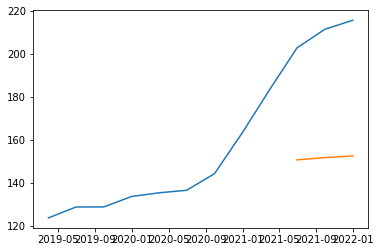

In [ ]:
## Long short term memory

# LSTM has three gates:
# The input gate: The input gate adds information to the cell state
# The forget gate: It removes the information that is no longer required by the model
# The output gate: Output Gate at LSTM selects the information to be shown as output

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

ex2 = example_data.copy()
ex2.index = ex2.time
ex2.drop('time', axis=1, inplace=True)
train = ex2[:-3]
valid = ex2[-3:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ex2)

x_train, y_train = [], []

for i in range(3,len(train)):
    x_train.append(scaled_data[i-3:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=3, 
               return_sequences=True, 
               input_shape=(x_train.shape[1],1))
)
model.add(LSTM(units=3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=0)

#predicting 3 values, using past 3 from the train data
inputs = ex2[len(ex2) - len(valid) - 3:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(3,inputs.shape[0]):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_mod = model.predict(X_test)
pred = scaler.inverse_transform(pred_mod)

rms=np.sqrt(np.mean(np.power((valid-pred),2)))
print(rms)

pred_df = val_set.copy()
pred_df['pred'] = pred
print(pred_df)

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

# does not perform well: may be due to limited data size.

In [ ]:
def prophet():
    ## Facebook's Prophet 
    ## Desigend for daily data --> not appropriate for our csae

    # from fbprophet import Prophet
    ## The input for Prophet is a dataframe with two columns: date and target (ds and y).
    ## Prophet tries to capture the seasonality in the past data and works well when the dataset is large.

    # #preparing data

    # ph_data = d_data[['CDUID','conn_type', 'time', 'avg_d_mbps']].rename(columns={'time': 'ds', 'avg_d_mbps':'y'})

    # ph_preds = pd.DataFrame(data= ar_train[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
    # ph_preds['prophet'] = 0

    # prs = ph_data['CDUID'].unique()
    # for pr in prs:
    #     ph_set = ph_data.loc[ph_data['CDUID']==pr, :]
    #     tp_set = ph_set['conn_type'].unique()
    #     for tp in tp_set:
    #         ph_subset = ph_set.loc[ph_set['conn_type'] == tp, ['ds', 'y']]
    #         # ph_subset.index = ph_subset['ds']
    #         try:
    #             ph_train = ph_subset.loc[ph_subset['ds']!= val_time, :]
    #             ph_val = ph_subset.loc[ph_subset['ds']== val_time, :]

    #             ph_model = Prophet()
    #             ph_model.fit(ph_train)

    #             ph_pred = ph_model.make_future_dataframe(periods = len(ph_val))
    #         except:
    #             ph_pred = np.array(ph_subset.loc[:, 'y'])[-1]

    #         ph_pred_idx = (ph_preds['CDUID']==pr) & (ph_preds['conn_type'] == tp)
    #         ph_preds.loc[ph_pred_idx, 'prophet'] = ph_pred


    # f_set3 = pd.merge(f_set2, ph_preds, how='left', on = ['CDUID', 'conn_type'])

    # ## RMSE of the ARIMA model
    # ph_rmse = np.sqrt(np.sum(np.square(f_set3.loc[:, 'prophet'] - f_set3.loc[:, 'avg_d_mbps'])) / len(f_set3))
    # ph_rmse

    return NA